# 3D Clustering Data Visualization

Interactive visualization and analysis of 3D point cloud data with measurement uncertainty (covariance matrices).

## 1. Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import cdist
import warnings
import os
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed

warnings.filterwarnings('ignore')

# Set style for matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries loaded successfully!")
#print(f"Plotly version: {px.__version__}")

Libraries loaded successfully!


## 2. Data Loading Functions

In [2]:
class ClusterDataLoader:
    """Load and parse clustering data files"""
    
    @staticmethod
    def load_viz_format(filename):
        """Load simplified visualization format (x y z cluster_id uncertainty)"""
        data = []
        with open(filename, 'r') as f:
            for line in f:
                if line.startswith('#'):
                    continue
                parts = line.strip().split()
                if len(parts) >= 4:
                    x, y, z = float(parts[0]), float(parts[1]), float(parts[2])
                    cluster_id = int(parts[3])
                    uncertainty = float(parts[4]) if len(parts) > 4 else 1.0
                    data.append([x, y, z, cluster_id, uncertainty])
        
        df = pd.DataFrame(data, columns=['x', 'y', 'z', 'cluster_id', 'uncertainty'])
        return df
    
    @staticmethod
    def load_full_format(filename):
        """Load full format with covariance matrices"""
        points = []
        covariances = []
        cluster_ids = []
        
        with open(filename, 'r') as f:
            for line in f:
                if line.startswith('#'):
                    continue
                parts = line.strip().split()
                if len(parts) >= 10:
                    # Position
                    x, y, z = float(parts[0]), float(parts[1]), float(parts[2])
                    points.append([x, y, z])
                    
                    # Covariance matrix (upper triangular)
                    cov = np.array([
                        [float(parts[3]), float(parts[4]), float(parts[5])],
                        [float(parts[4]), float(parts[6]), float(parts[7])],
                        [float(parts[5]), float(parts[7]), float(parts[8])]
                    ])
                    covariances.append(cov)
                    
                    # Cluster ID
                    cluster_id = int(parts[9]) if len(parts) > 9 else -1
                    cluster_ids.append(cluster_id)
        
        # Create DataFrame
        df = pd.DataFrame(points, columns=['x', 'y', 'z'])
        df['cluster_id'] = cluster_ids
        
        # Add covariance-derived features
        eigenvalues = []
        max_uncertainty = []
        anisotropy = []
        
        for cov in covariances:
            eigvals = np.linalg.eigvalsh(cov)
            eigenvalues.append(eigvals)
            max_uncertainty.append(np.max(eigvals))
            if np.min(eigvals) > 0:
                anisotropy.append(np.max(eigvals) / np.min(eigvals))
            else:
                anisotropy.append(1.0)
        
        df['max_uncertainty'] = max_uncertainty
        df['anisotropy'] = anisotropy
        
        return df, covariances

# Load data function with file browser
def load_data_interactive():
    """Interactive data loader with file selection"""
    file_widget = widgets.FileUpload(
        accept='.txt',
        multiple=False,
        description='Upload Data'
    )
    
    format_widget = widgets.RadioButtons(
        options=['Visualization Format', 'Full Format'],
        value='Visualization Format',
        description='Format:'
    )
    
    display(widgets.VBox([file_widget, format_widget]))
    return file_widget, format_widget


In [3]:
# Default file loading (modify paths as needed)
def load_default_data(viz_file='clustering_data_viz.txt', full_file='clustering_data.txt'):
    """Load default data files if they exist"""
    df = None
    covariances = None
    
    if os.path.exists(viz_file):
        print(f"Loading visualization format from: {viz_file}")
        df = ClusterDataLoader.load_viz_format(viz_file)
    elif os.path.exists(full_file):
        print(f"Loading full format from: {full_file}")
        df, covariances = ClusterDataLoader.load_full_format(full_file)
    else:
        print("No data files found. Please generate data first using:")
        print("  ./data_generator 5 1000")
        return None, None
    
    return df, covariances

# Load data
df, covariances = load_default_data()

if df is not None:
    print(f"Loaded {len(df)} points")
    print(f"Clusters: {df['cluster_id'].nunique()}")
    print("\nFirst few points:")
    display(df.head())


Loading visualization format from: clustering_data_viz.txt
Loaded 10000 points
Clusters: 6

First few points:


x          y          z  cluster_id  uncertainty
0  25.582933  -2.720513 -15.457328           1     0.142820
1 -20.662269 -21.530329  -8.673511           3     0.451135
2 -24.211658 -21.527162  -7.943860           3     0.245513
3  39.580927 -41.326262  60.494549          -1     1.436812
4  23.563775  -5.703443 -14.156460           1     0.311659

In [4]:
# ## 3. Dataset Statistics and Analysis

In [5]:
def analyze_dataset(df):
    """Comprehensive statistical analysis of the dataset"""
    
    stats_data = []
    
    # Overall statistics
    total_points = len(df)
    unique_clusters = df['cluster_id'].unique()
    n_clusters = len(unique_clusters[unique_clusters != -1])
    n_outliers = len(df[df['cluster_id'] == -1])
    
    print("="*50)
    print("DATASET OVERVIEW")
    print("="*50)
    print(f"Total Points: {total_points:,}")
    print(f"Number of Clusters: {n_clusters}")
    print(f"Number of Outliers: {n_outliers} ({100*n_outliers/total_points:.1f}%)")
    
    # Bounding box
    bbox_min = df[['x', 'y', 'z']].min()
    bbox_max = df[['x', 'y', 'z']].max()
    bbox_range = bbox_max - bbox_min
    
    print(f"\nBounding Box:")
    print(f"  Min: [{bbox_min.values}]")
    print(f"  Max: [{bbox_max.values}]")
    print(f"  Range: [{bbox_range.values}]")
    
    # Per-cluster statistics
    print("\n" + "="*50)
    print("CLUSTER STATISTICS")
    print("="*50)
    
    cluster_stats = []
    
    for cluster_id in sorted(unique_clusters):
        if cluster_id == -1:
            label = "Outliers"
        else:
            label = f"Cluster {cluster_id}"
            
        cluster_data = df[df['cluster_id'] == cluster_id]
        n_points = len(cluster_data)
        
        if n_points > 0:
            center = cluster_data[['x', 'y', 'z']].mean()
            std_dev = cluster_data[['x', 'y', 'z']].std()
            
            cluster_stats.append({
                'Cluster': label,
                'Points': n_points,
                'Center X': center['x'],
                'Center Y': center['y'],
                'Center Z': center['z'],
                'Std X': std_dev['x'],
                'Std Y': std_dev['y'],
                'Std Z': std_dev['z']
            })
            
            if 'uncertainty' in df.columns:
                avg_uncertainty = cluster_data['uncertainty'].mean()
                cluster_stats[-1]['Avg Uncertainty'] = avg_uncertainty
    
    stats_df = pd.DataFrame(cluster_stats)
    display(stats_df.round(3))
    
    return stats_df

if df is not None:
    stats_df = analyze_dataset(df)

DATASET OVERVIEW
Total Points: 10,000
Number of Clusters: 5
Number of Outliers: 500 (5.0%)

Bounding Box:
  Min: [[-74.842258 -74.451731 -74.992486]]
  Max: [[74.881597 74.634991 74.825719]]
  Range: [[149.723855 149.086722 149.818205]]

CLUSTER STATISTICS


Cluster  Points  Center X  Center Y  Center Z   Std X   Std Y   Std Z  \
0   Outliers     500    -0.699    -0.563    -0.989  42.542  44.671  43.857   
1  Cluster 0    1408    11.203    20.594   -24.109   1.638   2.358   2.884   
2  Cluster 1    2459    24.270    -4.495   -15.048   2.238   2.351   1.533   
3  Cluster 2    1925    -4.313   -21.669    23.273   1.111   1.418   1.249   
4  Cluster 3    1967   -22.877   -21.351    -8.841   2.617   1.965   1.933   
5  Cluster 4    1741    14.572     3.478     0.985   2.514   2.384   2.338   

   Avg Uncertainty  
0            1.733  
1            0.274  
2            0.275  
3            0.274  
4            0.274  
5            0.277

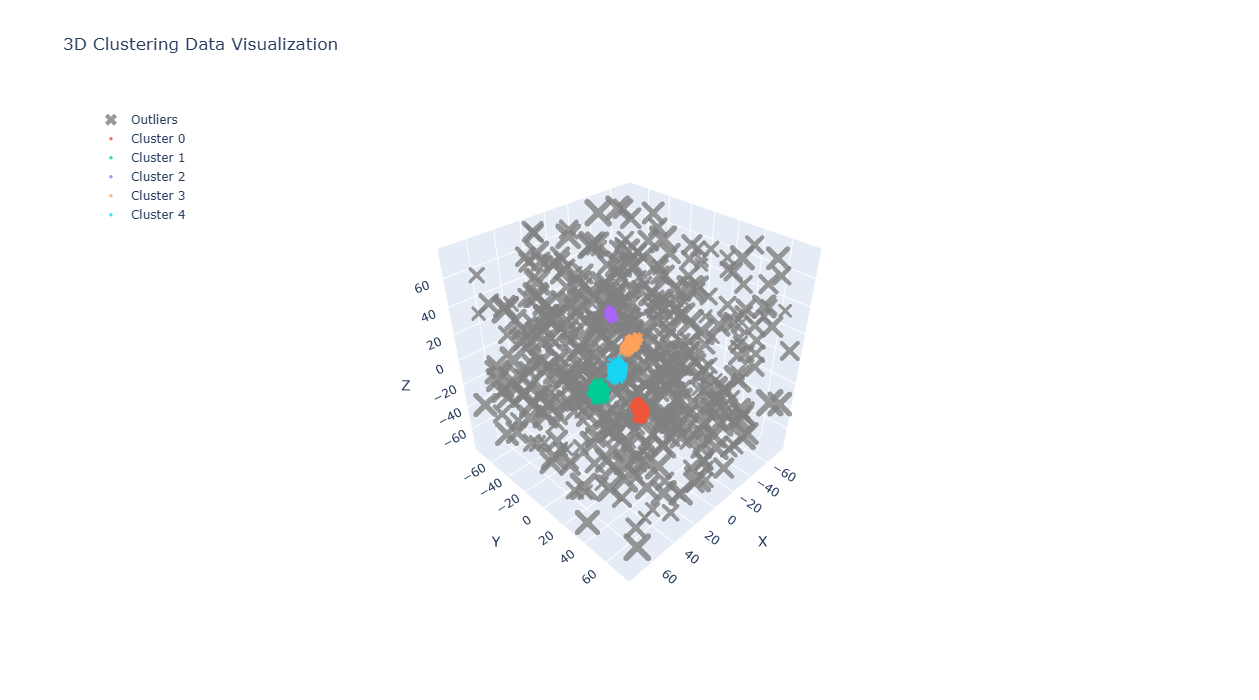

In [6]:
def create_3d_scatter_plotly(df, show_outliers=True, point_size=3, opacity=0.8):
    """Create interactive 3D scatter plot using Plotly"""
    
    # Prepare data
    plot_df = df.copy()
    if not show_outliers:
        plot_df = plot_df[plot_df['cluster_id'] != -1]
    
    # Create color mapping
    unique_clusters = sorted(plot_df['cluster_id'].unique())
    colors = px.colors.qualitative.Plotly + px.colors.qualitative.Set1
    color_map = {cid: colors[i % len(colors)] for i, cid in enumerate(unique_clusters)}
    color_map[-1] = 'gray'  # Outliers in gray
    
    # Create figure
    fig = go.Figure()
    
    # Add traces for each cluster
    for cluster_id in unique_clusters:
        cluster_data = plot_df[plot_df['cluster_id'] == cluster_id]
        
        if cluster_id == -1:
            name = 'Outliers'
            marker_symbol = 'x'
        else:
            name = f'Cluster {cluster_id}'
            marker_symbol = 'circle'
        
        # Size based on uncertainty if available
        if 'uncertainty' in cluster_data.columns:
            sizes = 2 + cluster_data['uncertainty'] * 5
        elif 'max_uncertainty' in cluster_data.columns:
            sizes = 2 + cluster_data['max_uncertainty'] * 5
        else:
            sizes = point_size
        
        fig.add_trace(go.Scatter3d(
            x=cluster_data['x'],
            y=cluster_data['y'],
            z=cluster_data['z'],
            mode='markers',
            name=name,
            marker=dict(
                size=sizes,
                color=color_map[cluster_id],
                opacity=opacity,
                symbol=marker_symbol,
                line=dict(width=0)
            ),
            text=[f'Point {i}<br>Cluster: {cluster_id}' for i in cluster_data.index],
            hovertemplate='%{text}<br>X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}'
        ))
    
    # Update layout
    fig.update_layout(
        title='3D Clustering Data Visualization',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            ),
            aspectmode='auto'
        ),
        height=700,
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )
    
    return fig

# Create interactive plot
if df is not None:
    fig = create_3d_scatter_plotly(df)
    fig.show()

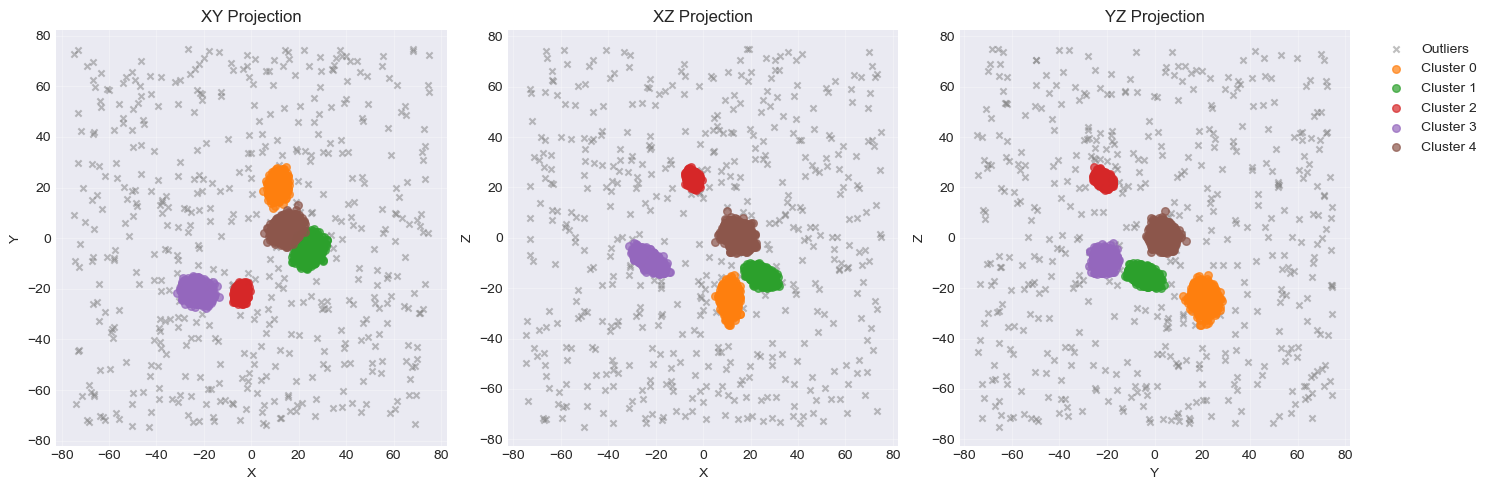

In [7]:
# ## 6. 2D Projections

# In[7]:


def plot_2d_projections(df, figsize=(15, 5)):
    """Create 2D projections of the 3D data"""
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    projections = [
        ('x', 'y', 'XY Projection'),
        ('x', 'z', 'XZ Projection'),
        ('y', 'z', 'YZ Projection')
    ]
    
    unique_clusters = sorted(df['cluster_id'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, max(10, len(unique_clusters))))
    color_map = {cid: colors[i % len(colors)] for i, cid in enumerate(unique_clusters)}
    color_map[-1] = 'gray'
    
    for ax, (dim1, dim2, title) in zip(axes, projections):
        for cluster_id in unique_clusters:
            cluster_data = df[df['cluster_id'] == cluster_id]
            
            if cluster_id == -1:
                ax.scatter(cluster_data[dim1], cluster_data[dim2],
                          c='gray', marker='x', s=20, alpha=0.5, label='Outliers')
            else:
                ax.scatter(cluster_data[dim1], cluster_data[dim2],
                          c=[color_map[cluster_id]], s=30, alpha=0.7,
                          label=f'Cluster {cluster_id}')
        
        ax.set_xlabel(dim1.upper())
        ax.set_ylabel(dim2.upper())
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        
        if ax == axes[-1]:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

if df is not None:
    plot_2d_projections(df)

## 11. Export and Save Results

In [8]:
def export_analysis_results(df, stats_df, output_prefix='analysis'):
    """Export analysis results to files"""
    
    # Save statistics to CSV
    stats_file = f"{output_prefix}_stats.csv"
    stats_df.to_csv(stats_file, index=False)
    print(f"Statistics saved to: {stats_file}")
    
    # Save summary report
    report_file = f"{output_prefix}_report.txt"
    with open(report_file, 'w') as f:
        f.write("Clustering Data Analysis Report\n")
        f.write("="*50 + "\n\n")
        
        f.write(f"Total Points: {len(df)}\n")
        f.write(f"Number of Clusters: {len(df['cluster_id'].unique()) - 1}\n")
        f.write(f"Outliers: {len(df[df['cluster_id'] == -1])}\n\n")
        
        f.write("Cluster Statistics:\n")
        f.write(stats_df.to_string())
        
    print(f"Report saved to: {report_file}")
    
    # Create HTML report with plots
    html_file = f"{output_prefix}_report.html"
    
    html_content = f"""
    <html>
    <head>
        <title>Clustering Analysis Report</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 40px; }}
            h1 {{ color: #333; }}
            table {{ border-collapse: collapse; width: 100%; }}
            th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
            th {{ background-color: #4CAF50; color: white; }}
        </style>
    </head>
    <body>
        <h1>Clustering Data Analysis Report</h1>
        <h2>Dataset Overview</h2>
        <p>Total Points: {len(df)}</p>
        <p>Number of Clusters: {len(df['cluster_id'].unique()) - 1}</p>
        <p>Outliers: {len(df[df['cluster_id'] == -1])}</p>
        
        <h2>Cluster Statistics</h2>
        {stats_df.to_html()}
    </body>
    </html>
    """
    
    with open(html_file, 'w') as f:
        f.write(html_content)
    
    print(f"HTML report saved to: {html_file}")

# Uncomment to export results
# if df is not None and stats_df is not None:
#     export_analysis_results(df, stats_df)
